In [1]:
import time


def compare_runtime(
    configuration: dict, algorithms: list[tuple[str, any]], verbose=False
):
    results = {}
    for alg_name, alg in algorithms:
        start_time = time.process_time()
        alg(**configuration)
        end_time = time.process_time()
        results[alg_name] = end_time - start_time
        if verbose:
            print(f"Finished with {alg_name}")
    return results

In [2]:
import causalpathalgorithms

algorithms = [
    ("PaCo", causalpathalgorithms.PaCo),
    ("PaCo2", causalpathalgorithms.PaCo2),
    ("Baseline", causalpathalgorithms.pathpy_causal_paths),
]

In [3]:
import utils

(_, college_msg_edge_set) = utils.read_time_stamped_csv(
    "data/college-msg.csv", "datetime"
)

/Users/jellekeulemans/Projects/SocialNetworks/PaCo/utils.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset_df[timestamp_column] = pd.to_datetime(dataset_df[timestamp_column])


In [4]:
import pandas as pd

pd.set_option("display.width", 2000)

In [9]:
import datetime
import pandas as pd


def exp_runtime(dataset_sorted_edges, verbose=False):
    edge_list_size_step = int(len(dataset_sorted_edges) / 5)
    # dictionary containing parameter keys and the values that we want to test. Each value is a tuple containing
    # the readable format and the real parameter
    alg_parameter_ranges = {
        "sorted_edges": range(
            edge_list_size_step,
            len(dataset_sorted_edges) + 1,
            edge_list_size_step,
        ),
        "delta_time": range(10, 51, 10),
        "max_path_length": range(1, 7),
    }
    alg_parameter_defaults = {
        "sorted_edges": len(dataset_sorted_edges),
        "delta_time": 30,
        "max_path_length": 4,
    }
    parameter_preprocessors = {
        "sorted_edges": lambda n: dataset_sorted_edges[:n],
        # "delta_time": lambda m: datetime.timedelta(minutes=m),
        "delta_time": lambda m: m * 60,
    }

    results = []

    for param_key in alg_parameter_ranges.keys():
        if verbose:
            print(f"testing {param_key}")
        for param_value in alg_parameter_ranges[param_key]:
            # Merge defaults with current iteration
            readable_params = alg_parameter_defaults | {param_key: param_value}

            # Apply processing to readable parameters to create proper parameters like an edge set or timedelta object
            processed_params = readable_params.copy()
            for processor_key, processor in parameter_preprocessors.items():
                processed_params[processor_key] = processor(
                    readable_params[processor_key]
                )

            runtimes_dict = compare_runtime(processed_params, algorithms, verbose)
            current_result = runtimes_dict | {"experiment": param_key} | readable_params
            results.append(current_result)

    return results

In [10]:
from matplotlib import pyplot as plt


def plot_K(df):
    n_df = df[df["experiment"] == "max_path_length"]
    plt.figure(figsize=(2 ^ 4, (3 * (2 ^ 4)) / 4))
    for algorithm, _ in algorithms:
        plt.plot(n_df["max_path_length"], n_df[algorithm], label=algorithm)
    plt.xlabel("K")
    plt.xticks(n_df["max_path_length"])
    plt.ylabel("run-time [s]")
    plt.legend(loc="upper right")
    plt.title(
        "Run-time of three causal path finding algorithms for varying max path lengths"
    )

    plt.tight_layout()
    plt.show()


def plot_N(df):
    n_df = df[df["experiment"] == "sorted_edges"]
    plt.figure(figsize=(2 ^ 4, (3 * (2 ^ 4)) / 4))
    for algorithm, _ in algorithms:
        plt.plot(n_df["sorted_edges"], n_df[algorithm], label=algorithm)
    plt.xlabel("N")
    plt.ylabel("run-time [s]")
    plt.legend(loc="upper right")
    plt.title(
        "Run-time of three causal path finding algorithms for varying network size"
    )

    plt.tight_layout()
    plt.show()


def plot_dt(df):
    n_df = df[df["experiment"] == "delta_time"]
    plt.figure(figsize=(2 ^ 4, (3 * (2 ^ 4)) / 4))
    for algorithm, _ in algorithms:
        plt.plot(n_df["delta_time"], n_df[algorithm], label=algorithm)
    plt.xlabel("delta_time [min]")
    plt.ylabel("run-time [s]")
    plt.legend(loc="upper right")
    plt.title("Run-time of three causal path finding algorithms for varying delta time")

    plt.tight_layout()
    plt.show()


def plot_all(df):
    plot_K(df)
    plot_N(df)
    plot_dt(df)

In [ ]:
(_, reality_mining_edge_set) = utils.read_time_stamped_csv("data/reality-mining.csv")

# timestamps = [time_dict["Timestamp"] for (_, _, time_dict) in reality_mining_edge_set]
# print(calculate_time_stats(timestamps))

runtime_exp_results = exp_runtime(reality_mining_edge_set)
runtime_exp_results_df = pd.DataFrame(runtime_exp_results)
print(runtime_exp_results_df[runtime_exp_results_df["experiment"] == "delta_time"])

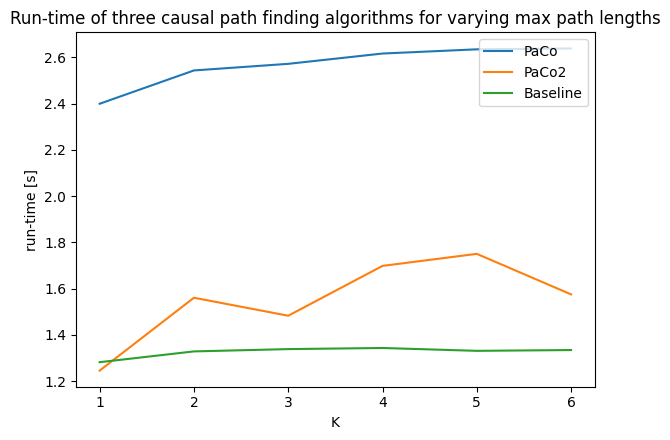

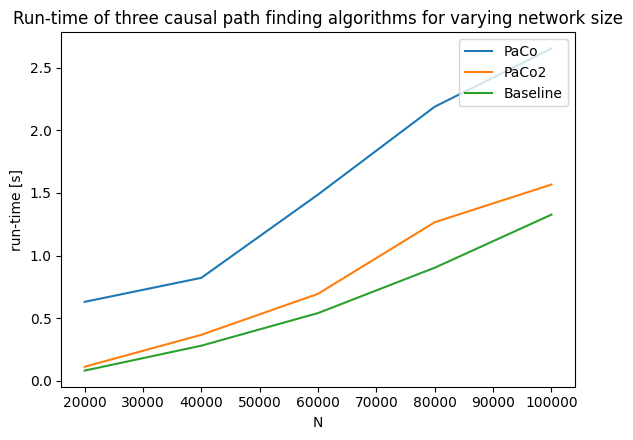

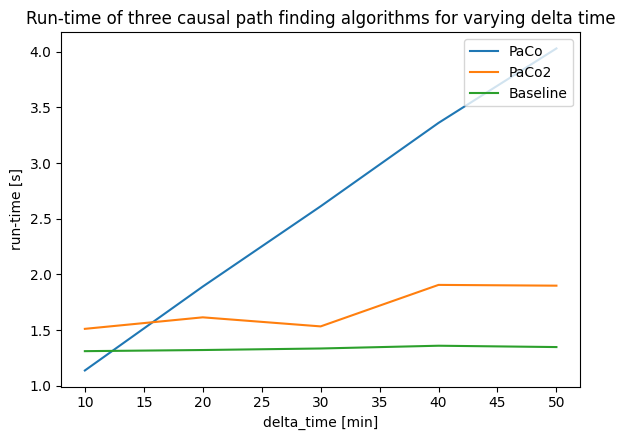

In [12]:
plot_all(runtime_exp_results_df)